In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd
%cd /content/drive/My\ Drive/
%cd Colab Notebooks (1)/Release_All_final

/content
/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks (1)/Release_All_final


In [3]:
%matplotlib inline
%load_ext autoreload
# %autoreload 2

In [4]:

from __future__ import print_function
import os                                    
import sys
import numpy as np 
import torch
from matplotlib import pyplot
import warnings
warnings.filterwarnings("ignore")

In [5]:
cuda = True
model_dir =  '/content/drive/MyDrive/Colab Notebooks (1)/Release_All_final/trained_model/'
CoMoFoD_hd5 = '/content/drive/MyDrive/datasets/CASIA-CMFD-Pos (1).hd5'

sys.path.insert( 0, model_dir )
from net import BusterNet
model = BusterNet(256)

model.load_state_dict(torch.load(f'{model_dir}/buster_epoch_13.pth'))
if cuda: 
    model = model.cuda()

In [6]:
import h5py
f = h5py.File(CoMoFoD_hd5, 'r')
# 1. load HDF5 data
print(f.keys())
X  = f['X']
Y  = f['Y']
print(X.shape, Y.shape)

<KeysViewHDF5 ['X', 'Y']>
(1313, 256, 256, 3) (1313, 256, 256, 3)


In [7]:
# Z = busterNetModel.predict(X, verbose=1)

batch_size = 16
size = len(X) // batch_size
Z = []
for i in range(size + 1):
    if batch_size == size:
        x = X[i * batch_size:]
    else:
        x = X[i * batch_size: (i + 1) * batch_size]
    x = torch.tensor(x).permute(0, 3, 1, 2)
    
    if cuda:
        x = x.cuda()

    model.eval()
    with torch.no_grad():
        z, _, _ = model(x)
    Z.append(z.cpu())
    
Z = torch.cat(Z)

Z = Z.permute(0, 2, 3, 1).numpy()

# 3. BusterNet Performance using Pixel-Level Evaluation Protocal-B¶


In [8]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_protocal_B( Y, Z ) :
    # compute scores for each sample
    prf_list = []
    for rr, hh in zip( Y, Z ) :
        ref = rr[...,-1].ravel() == 0 # because the last channel is "pristine"
        hyp = hh[...,-1].ravel() <= 0.5 # convert to binary
        precision, recall, fscore, _ = precision_recall_fscore_support( ref, hyp,
                                                                        pos_label=1, 
                                                                        average='binary' )
        prf_list.append( [precision, recall, fscore] )
    # stack list to an array 
    prf = np.row_stack( prf_list )
    # print out results
    print( "INFO: BusterNet Performance on CASIA-CMFD Dataset using Pixel-Level Evaluation Protocal-B" )
    print("-" * 100)
    for name, mu in zip( ['Precision', 'Recll', 'F1'], prf.mean(axis=0) ) :
        print( "INFO: {:>9s} = {:.3f}".format( name, mu ) )
    return prf

In [9]:
prf_list = evaluate_protocal_B( Y, Z )

INFO: BusterNet Performance on CASIA-CMFD Dataset using Pixel-Level Evaluation Protocal-B
----------------------------------------------------------------------------------------------------
INFO: Precision = 0.097
INFO:     Recll = 0.745
INFO:        F1 = 0.153


# 4. BusterNet's Discernibility Performance¶


In [10]:
def check_one_sample( z, y ) :
    """Check BusterNet's Discernibility for one sample
    Input:
        z = np.array, BusterNet predicted mask
        y = np.array, GT mask
    Output:
        src_label = the dominant class on the src copy, if 0 then correct
        dst_label = the dominant class on the dst copy, if 1 then correct
    """
    def hist_count( arr ) :
        nb_src = np.sum( arr == 0 )
        nb_dst = np.sum( arr == 1 )
        nb_bkg = np.sum( arr == 2 )
        return [nb_src, nb_dst, nb_bkg ]
    def get_label( hist ) :
        if np.sum( hist[:2] ) == 0 :
            return 2
        else :
            return np.argmax( hist[:2] )
    # 1. determine pixel membership from the probability map
    hyp = z.argmax( axis = -1 ) 
    # 2. get the gt src/dst masks
    ref_src = y[...,0]>0.5
    ref_dst = y[...,1]>0.5
    # 3. count the membership histogram on src/dst masks respectively
    src_hist = hist_count( hyp[ ref_src ] )
    src_label = get_label( src_hist )
    dst_hist = hist_count( hyp[ ref_dst ] )
    dst_label = get_label( dst_hist )
    return src_label, dst_label

def evaluate_discernibility( Z, Y ) :
    lut = dict()
    lut = {(s, d): 0 for s in range(3) for d in range(3)}
    for idx, (z, y) in enumerate( zip( Z, Y ) ) :
        src_label, dst_label = check_one_sample( z, y.astype('float32') )
        key = ( src_label, dst_label )
#         print(key)
        if key not in lut :
            lut[key] = 0
        lut[key] += 1
    # print results
    print("INFO: BusterNet's Discernibility Performance Analysis")
    print("-" * 100)
    total = np.sum( list(lut.values()) )
    print("{:<12s} = {}".format( 'Total', total ))
    print("{:<12s} = {}".format( 'Miss',  np.sum( [lut[(2,k)] for k in range(3)] \
                                                +[lut[(k,2)] for k in range(3)] ) \
                                                -lut[2,2] ) )
    print("{:<12s} = {}".format( 'OptOut', lut[(1,1)] + lut[(0,0)] ) )
    print("{:<12s} = {}".format( 'OptIn', lut[(0,1)] + lut[(1,0)] ) )
    print("{:<12s} = {}".format( 'Correct', lut[(0,1)] ) )
    print("-" * 100)
    print("{:<12s} = {:.3f}".format( 'Overall-Acc.', float(lut[(0,1)])/total ) )
    print("{:<12s} = {:.3f}".format( 'OptIn-Acc.', float(lut[(0,1)])/float(lut[(0,1)]+lut[(1,0)] + 1e-2) ) )

In [11]:
evaluate_discernibility( Z, Y )

INFO: BusterNet's Discernibility Performance Analysis
----------------------------------------------------------------------------------------------------
Total        = 1313
Miss         = 6
OptOut       = 1165
OptIn        = 142
Correct      = 69
----------------------------------------------------------------------------------------------------
Overall-Acc. = 0.053
OptIn-Acc.   = 0.486


# 5. Generate qualitative results¶


In [12]:
def visualize_random_samples( X, Y, Z, batch_size=8, figsize=(12,4), prf_list=None, thresh=0.3 ) :
    nb_samples = X.shape[0]
    if prf_list is None :
        print("INFO: show random results")
        indices = np.random.choice( range(nb_samples), size=(batch_size,))
    else :
        print("INFO: show random results with F1 score > {}".format( thresh ) )
        candi = np.nonzero( prf_list[:,-1] > thresh )[0].tolist()
        indices = np.random.choice( candi, size=(batch_size,))
    for idx in indices :
        # 1. add back imageNet BGR means
        x = np.array(X[idx]) + np.array([103.939, 116.779, 123.68]).reshape([1,1,3])
        # 2. restore image dtype and BGR->RGB
        x = np.round(x).astype('uint8')[...,::-1]
        # 3. set gt to float
        y = np.array(Y[idx]).astype('float32')
        z = np.array(Z[idx])
        # 4. display
        pyplot.figure(figsize=figsize)
        pyplot.subplot(131)
        pyplot.imshow( x )
        pyplot.title('test image')
        pyplot.subplot(132)
        pyplot.imshow( y )
        pyplot.title('ground truth')
        pyplot.subplot(133)
        pyplot.imshow( z )
        pyplot.title('Modified BusterNet predicted')
    return

INFO: show random results with F1 score > 0.2


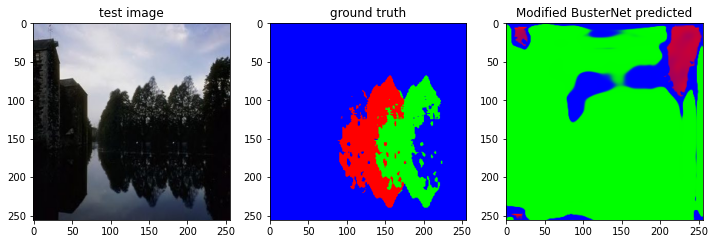

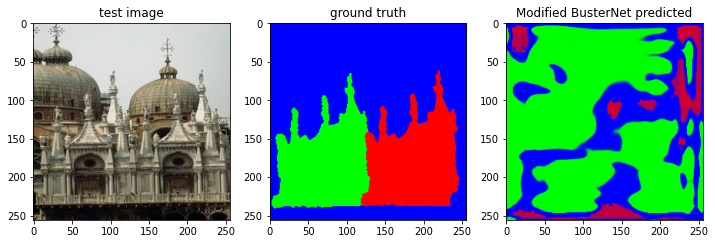

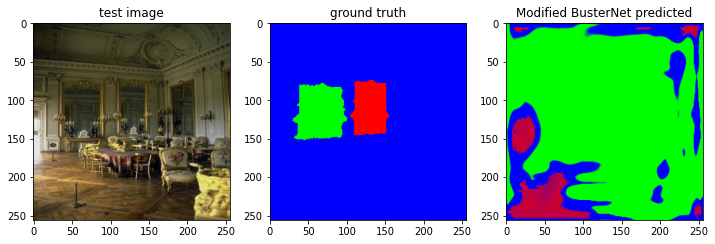

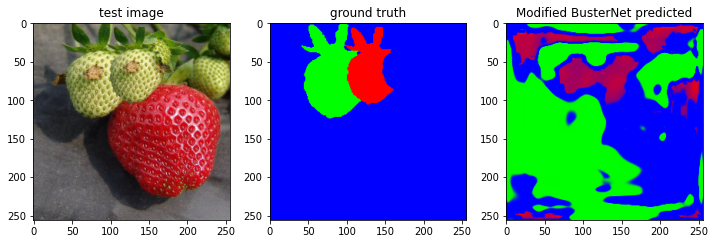

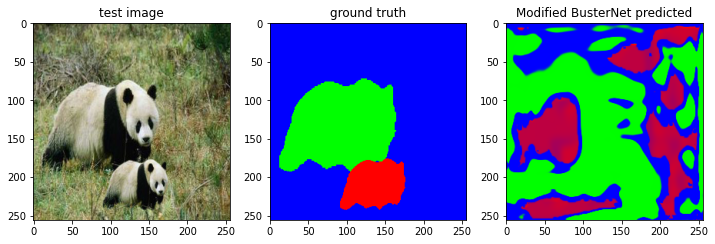

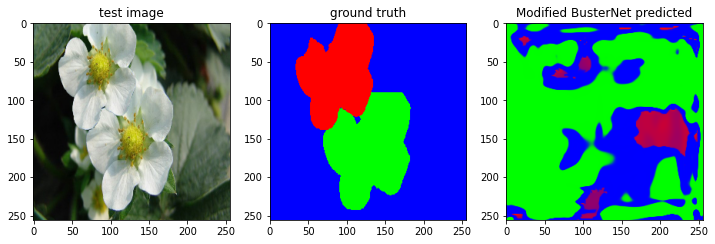

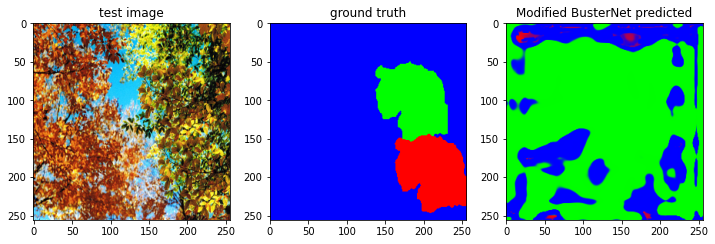

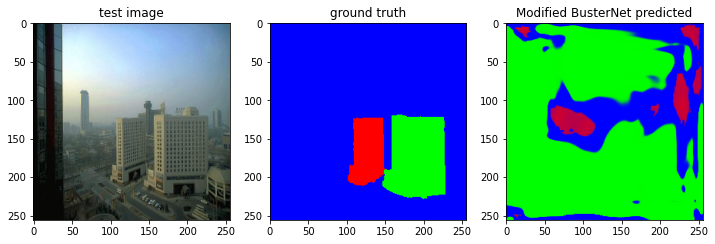

In [13]:

visualize_random_samples( X, Y, Z, prf_list=prf_list, thresh=0.2 )